In [18]:
# This repository uses publicly available data derived from the Swedish Adoption/Twin Study 
#   of Aging (SATSA), provided by the Inter-university Consortium for Political and 
#   Social Research (ICPSR). 
# 
# The data are licensed for secondary use and analysis. 
# Accessed via [ICPSR #4538](https://doi.org/10.3886/ICPSR03843.v2).
#
# Citation:
#   Pedersen, Nancy L. Swedish Adoption/Twin Study on Aging (SATSA), 1984, 1987, 1990, 1993, 2004, 2007, and 2010. 
#   Inter-university Consortium for Political and Social Research [distributor], 2015-05-13.

In [6]:
# This notebook uses SATSA longitudinal survey as a demonstration 
# dataset for the ECTO pipeline, as the 
# 'flagship' runs on which the ECTO system was first tested.
#
# Note that the ECTO ODE system was not written to accomodate either the dental student
# dataset nor the SATSA data set, nor longitudinal psychometric data, in general, but
# rather, the ECTO ODE system was written with biological evolution and complex
# systems principles in mind. 

In [20]:
#Example of Raw psychometric data from SATSA survey:
#
# Trait Proxy: A1: I want to be the best in everything
# Year: 1984
# 1 exactly right 78 
# 2 almost right 190 
# 3 neither right nor wrong 318 
# 4 not quite right 501 
# 5 not right at all 836
#
# Normalization is not done initially so as to avoid unnecessary dimensional reduction
#   ahead of the entropy conversion.

In [16]:
# This Notebook is the 'walk-through' for replicating
# the results in the ALife 2025 Late Breaking Abstract:
# lb162: 'Entropy Coupled Trait ODEs (ECTO) Reveal Structured Population 
# Dynamics in Longitudinal Psychometric Data'
# by Anderson M. Rodriguez
#
# Note, an earlier iteration of this work appears as:
# arXiv:2506.20622:  'Modeling Behavioral Traits 
# as Dynamical Systems: Entropy-based Analysis of Longitudinal 
# Psychometric Data with Coupled Ordinary Differential Equations',
# a work which is currently in revision for re-submission 
# following initial peer review.
#
#########################
#
# Overview for the Notebook:
# Entropy is extracted from the SATSA dataset, then fed into a series of
# recursively interacting ODEs which were designed with ecosystem 
# constraints in mind. The driven entropy signal is compartively
# forward-simulated against the empirical entropy signal.


In [ ]:
#Unhash to reproduce environment.
#
#import sys, numpy as np, scipy
#print("Python", sys.version.split()[0],
#      "| NumPy", np.__version__,
#      "| SciPy", scipy.__version__)
#np.set_printoptions(suppress=True, precision=6)


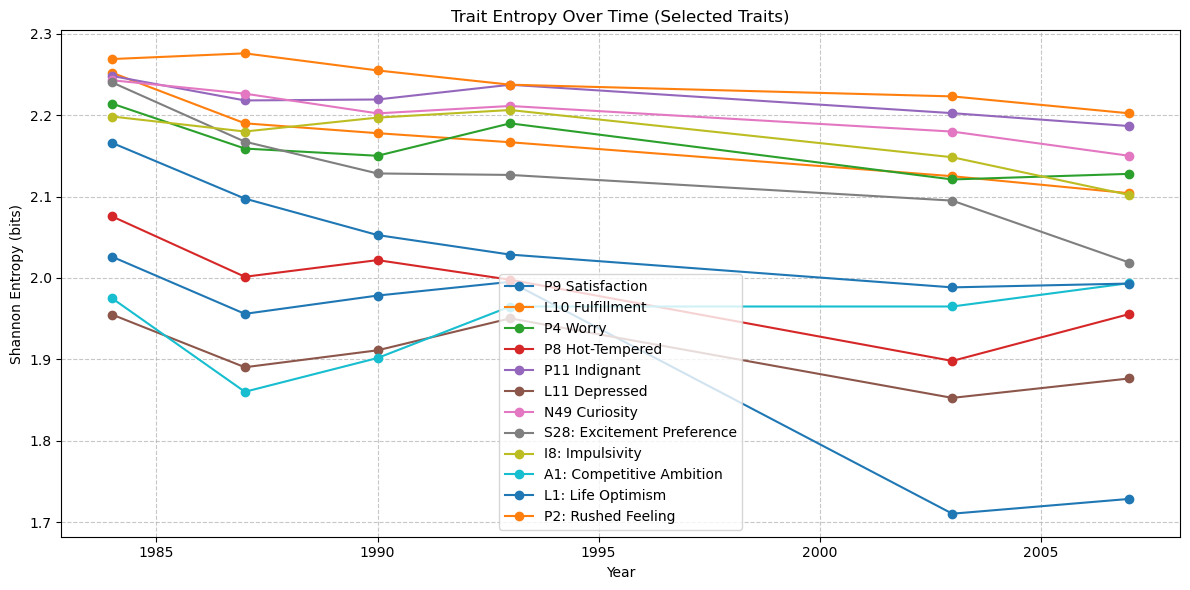

Trait                     Year    Entropy
P9 Satisfaction           1984     2.0260
P9 Satisfaction           1987     1.9559
P9 Satisfaction           1990     1.9783
P9 Satisfaction           1993     1.9952
P9 Satisfaction           2003     1.7102
P9 Satisfaction           2007     1.7284
L10 Fulfillment           1984     2.2521
L10 Fulfillment           1987     2.1900
L10 Fulfillment           1990     2.1779
L10 Fulfillment           1993     2.1668
L10 Fulfillment           2003     2.1250
L10 Fulfillment           2007     2.1041
P4 Worry                  1984     2.2142
P4 Worry                  1987     2.1590
P4 Worry                  1990     2.1501
P4 Worry                  1993     2.1900
P4 Worry                  2003     2.1210
P4 Worry                  2007     2.1279
P8 Hot-Tempered           1984     2.0755
P8 Hot-Tempered           1987     2.0014
P8 Hot-Tempered           1990     2.0219
P8 Hot-Tempered           1993     1.9978
P8 Hot-Tempered           2003    

In [22]:
# MODULE A_0: A script to extract entropy from raw SATSA data
#
# (Comparable with MODULE B_0 through B_2 of script ALife_ECTO_B_walkthrough_DENTAL.ipynb)
#
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Define Likert-scale trait frequency data
# Each list contains 5 Likert bin counts per year, from 1 (highest agreement) to 5 (lowest agreement)
# So, 1: exactly Right; 2. almost right; 3. neither right nor wrong; 4. not quite right; 5. not right at all
# The years are: 1984, 1987, 1990, 1993, 2003, 2007:
#
# Note: 
# These 12 trait matrices contain raw scores from arbitrarily selected traits assessed
# in the SATSA dataset.
#
# For the rest of the walkthrough we will select 2 traits which can be considered as 
# related, an 'N' trait, and a selected 'P' [pleiotropic] trait. 
#
# This is selecting of 'related' biologically inspired, but isn't a biochemical relation
#   in this iteration of the work.

trait_data = {
    "P9 Satisfaction": [
        [76, 231, 294, 611, 698], #Row 1984: Likert scores 1 → 5
        [48, 146, 248, 523, 593], #Row 1987: Same structure throughout
        [40, 125, 288, 480, 489], #Row 1990
        [29, 158, 289, 447, 480], #Row 1993
        [92, 443, 156, 68, 15],   #Row 2003
        [85, 354, 138, 40, 17]    #Row 2007
    ],
    "L10 Fulfillment": [
        [193, 348, 445, 539, 382],
        [114, 252, 448, 447, 291],
        [106, 230, 423, 424, 240],
        [92, 212, 461, 344, 290],
        [40, 110, 239, 235, 149],
        [25, 95, 197, 189, 126]
    ],
    "P4 Worry": [
        [159, 374, 325, 548, 527],
        [95, 241, 300, 476, 448],
        [74, 229, 309, 455, 359],
        [85, 250, 316, 391, 364],
        [29, 133, 175, 250, 185],
        [22, 113, 171, 179, 144]
    ],
    "P8 Hot-Tempered": [
        [124, 249, 287, 473, 780],
        [73, 162, 280, 360, 683],
        [60, 156, 254, 376, 576],
        [43, 179, 243, 350, 586],
        [12, 75, 137, 214, 335],
        [17, 59, 119, 178, 259]
    ],
    "P11 Indignant": [
        [185, 457, 334, 524, 415],
        [114, 332, 312, 448, 345],
        [101, 337, 329, 381, 280],
        [112, 353, 305, 344, 289],
        [53, 163, 204, 217, 139],
        [38, 139, 166, 176, 109]
    ],
    "L11 Depressed": [
        [103, 159, 269, 527, 855],
        [54, 105, 251, 450, 700],
        [38, 98, 263, 464, 563],
        [40, 114, 265, 453, 535],
        [13, 52, 135, 253, 323],
        [9, 43, 127, 200, 246]
    ],
    "N49 Curiosity": [
        [229, 520, 295, 310, 218],
        [116, 371, 402, 346, 287],
        [97, 343, 401, 319, 237],
        [99, 327, 385, 334, 245],
        [44, 196, 207, 189, 125],
        [31, 164, 193, 136, 103]
    ],
    "S28: Excitement Preference": [
        [168, 408, 514, 468, 348],
        [107, 365, 502, 360, 211],
        [94, 343, 505, 309, 168],
        [91, 341, 505, 285, 174],
        [38, 180, 287, 166, 101],
        [28, 140, 266, 128, 67]
    ],
    "I8: Impulsivity": [
        [189, 332, 263, 584, 556],
        [108, 241, 313, 457, 450],
        [110, 228, 294, 452, 343],
        [113, 236, 284, 437, 351],
        [46, 117, 181, 266, 165],
        [27, 84, 154, 214, 154]
    ],
    "A1: Competitive Ambition": [
        [78, 190, 318, 501, 836],
        [38, 98, 279, 455, 700],
        [34, 97, 292, 402, 600],
        [36, 131, 302, 368, 570],
        [16, 72, 184, 207, 297],
        [11, 67, 171, 170, 213]
    ],
    "L1: Life Optimism": [
        [278, 656, 515, 322, 156],
        [154, 444, 589, 238, 137],
        [117, 393, 569, 231, 112],
        [97, 363, 578, 264, 104],
        [36, 219, 316, 138, 63],
        [31, 156, 270, 121, 53]
    ],
    "P2: Rushed Feeling": [
        [337, 573, 274, 429, 312],
        [207, 435, 293, 368, 269],
        [149, 369, 310, 365, 237],
        [133, 411, 299, 327, 238],
        [54, 183, 185, 190, 162],
        [44, 146, 135, 191, 116]
    ],
}

years = [1984, 1987, 1990, 1993, 2003, 2007]

# Entropy extraction function:
def compute_entropy_per_year(freqs):
    entropies = []
    for year_data in freqs:
        dist = np.array(year_data, dtype=np.float64)
        dist /= dist.sum()  # Normalize
        entropies.append(entropy(dist, base=2))  # Shannon entropy, base 2
    return entropies

# Optional: visualize a few traits or all traits
if __name__ == "__main__":
    plt.figure(figsize=(12, 6))

    for trait in trait_data: #this will plot all traits
        e_vals = compute_entropy_per_year(trait_data[trait])
        plt.plot(years, e_vals, marker='o', label=trait)



    
    plt.title("Trait Entropy Over Time (Selected Traits)")
    plt.xlabel("Year")
    plt.ylabel("Shannon Entropy (bits)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Compute entropy per year per trait 
print(f"{'Trait':<25} {'Year':<6} {'Entropy':>8}")
print("=" * 42)

for trait, data in trait_data.items():
    for i, year_data in enumerate(data):
        probs = np.array(year_data) / np.sum(year_data)
        ent = entropy(probs, base=2)  # use base 2 for bits
        print(f"{trait:<25} {years[i]:<6} {ent:>8.4f}")


Manual Parameters:
mu = 0.00001, alpha =  0.00800, beta = 0.16031, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 0.00000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.4064
RMSE for P4 Worry: 0.2198
R² for P8 Hot-Tempered: -0.7206
R² for P4 Worry: 0.6118
Pearson r (N): 0.885 (p=0.019)
Pearson r (P): 0.805 (p=0.053)

DTW distance (N): 1.854
DTW distance (P): 0.712


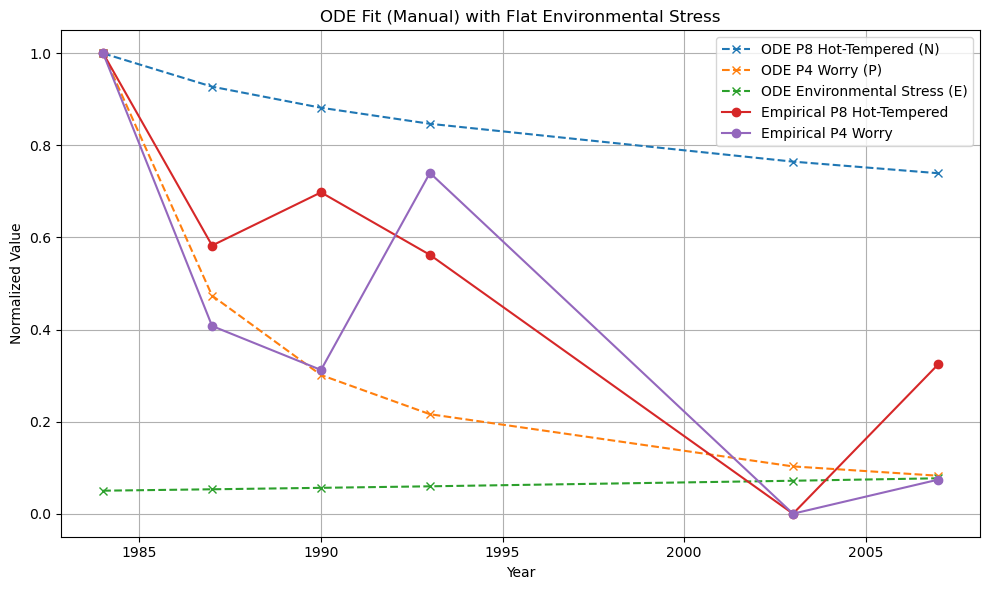

In [30]:
# MODULE A_1
#
# (Comparable with MODULE B_3 of script ALife_ECTO_B_walkthrough_DENTAL.ipynb)
#
# ECTO Nonlinear ODE System
#
# 'FIRST parameter Set', Manual parameter settings for illustrative purposes
#
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters (Default = False)
use_optimizer = False  # <<< Set to False to manually adjust parameters

# Trait Entropy Data (Import Likert-cum-entropy Data),
# We will select two of the following: 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

# Two selected traits
trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System without Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8  #Not utilized when E left flat
    amplitude = 0.05 #Not utilized when E left flat
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) 
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 0.8), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = 0.008
    beta  = 0.16031
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 0.0   # <- Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Flat Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Manual Parameters:
mu = 0.00001, alpha =  0.05300, beta = 0.16746, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 0.00000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.2117
RMSE for P4 Worry: 0.2205
R² for P8 Hot-Tempered: 0.5330
R² for P4 Worry: 0.6093
Pearson r (N): 0.886 (p=0.019)
Pearson r (P): 0.803 (p=0.054)

DTW distance (N): 0.834
DTW distance (P): 0.722


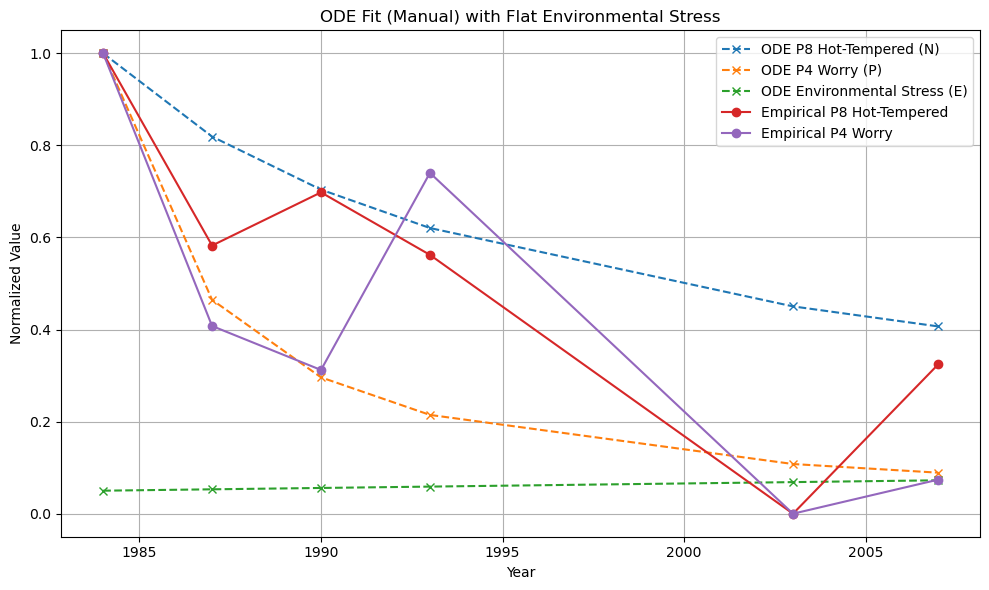

In [35]:
# MODULE A_2
#
# (Comparable with MODULE B_3 of script ALife_ECTO_B_walkthrough_DENTAL.ipynb)
#
# 'SECOND parameter Set': Manual parameter settings for illustrative purposes
#
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28: Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8: Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1: Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1: Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2: Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System without Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) 
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 0.8), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = 0.053
    beta  = 0.16746
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 0.0   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Flat Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Manual Parameters:
mu = 0.00001, alpha =  0.09800, beta = 0.17117, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 0.00000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.1552
RMSE for P4 Worry: 0.2205
R² for P8 Hot-Tempered: 0.7491
R² for P4 Worry: 0.6095
Pearson r (N): 0.879 (p=0.021)
Pearson r (P): 0.803 (p=0.055)

DTW distance (N): 0.648
DTW distance (P): 0.725


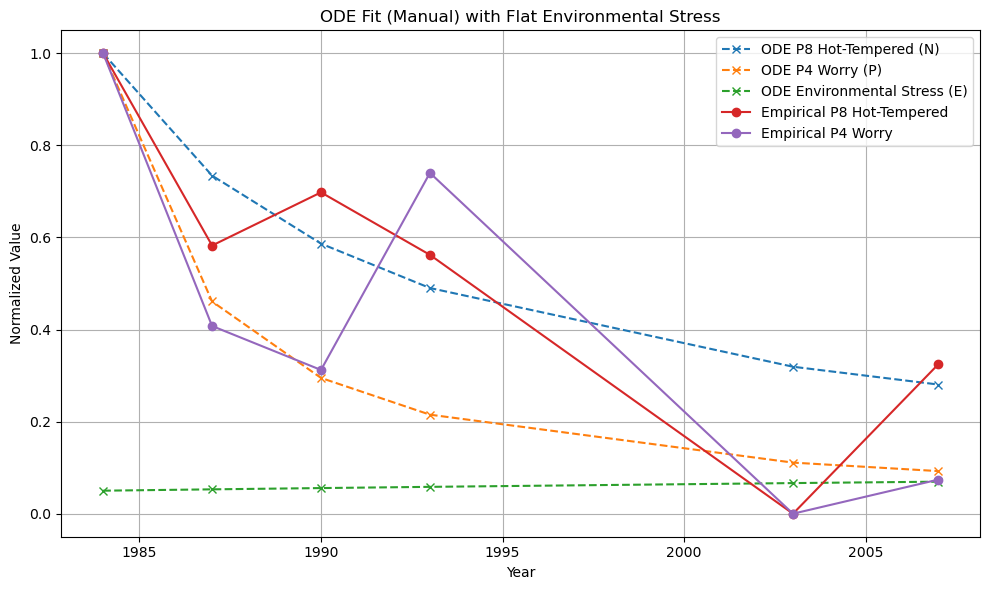

In [38]:
# MODULE A_3
#
# 'THIRD parameter Set': Manual parameter settings for illustrative purposes
#
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28: Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8: Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1: Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1: Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2: Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System without Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8 #incosequential with Flat E
    amplitude = 0.05 #inconsequential with Flat E
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) 
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 0.8), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = 0.098
    beta  = 0.17117
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 0.0   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Flat Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Manual Parameters:
mu = 0.00001, alpha =  0.09800, beta = 0.17117, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 12.60000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.1590
RMSE for P4 Worry: 0.2915
R² for P8 Hot-Tempered: 0.7367
R² for P4 Worry: 0.3176
Pearson r (N): 0.880 (p=0.021)
Pearson r (P): 0.777 (p=0.069)

DTW distance (N): 0.655
DTW distance (P): 0.783


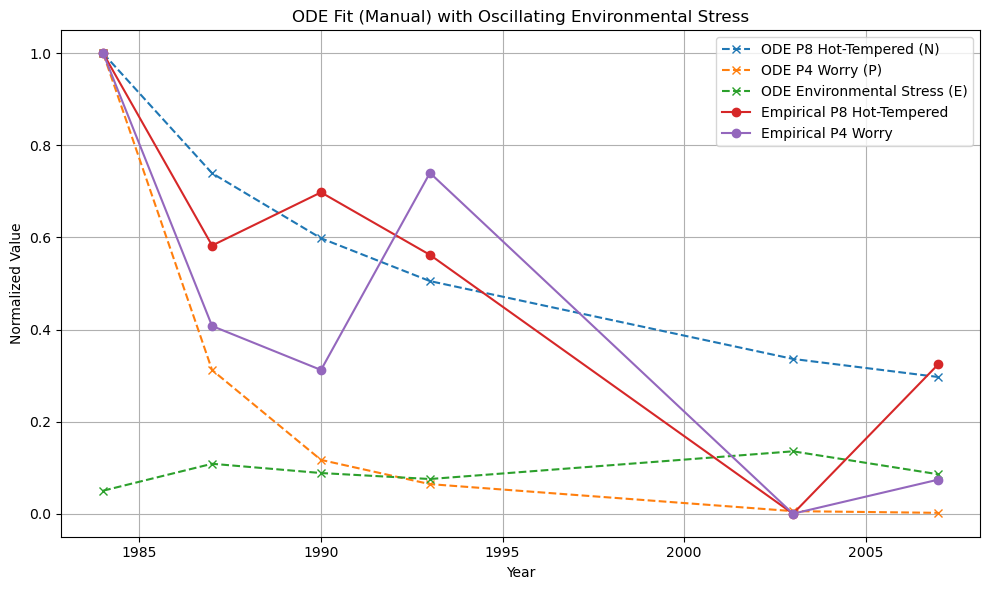

In [42]:
# MODULE A_4
#
# 'FOURTH parameter Set': Manual parameter settings for illustrative purposes
#
# Note: This module is able to run via L-BFGS-B Optimization, 
#   or with Manual Parameter fitting (Manual default shown)
#
# Additionally, a critical note, is that this is the first A_module which 
#   utilizes the E_stress parameter [manipulable as "c3"]
#
# All depicted parameterizations were selected for illustrative purposes 
#   for the A_series of modules. Optimized parameters were selected for
#   the Module B_series, which is run on a different 
#   dataset (see script ALife_ECTO_B_walkthrough_DENTAL.ipynb)
#
# So: this A_series of modules is manually calibrated for the ALife 25
#   Late Breaking Abstract-associated poster [and this associated repository],
#   while the B_series of modules [in script ALife_ECTO_B_walkthrough_DENTAL.ipynb]
#   is optimized with the L-BFGS-B scheme, again, both of which were selected
#   for illustrative purposes. 
#
# Further justification can be found in the preprint https://arxiv.org/abs/2506.20622,
#   and further testing has been done with high degrees of confidence outside of the
#   scope of this Late Breaking presentation.
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28: Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8: Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1: Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1: Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2: Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System with Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, beta, alpha, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 0.8), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = 0.098
    beta  = 0.17117
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 012.60   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Oscillating Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== LOO (hold one time point; fit on the other five) ===
Hold 1984 | N_true=1.000 N_pred=1.000 | P_true=1.000 P_pred=1.000 | CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL | SSE=0.358236
Hold 1987 | N_true=0.583 N_pred=0.729 | P_true=0.408 P_pred=0.740 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH | SSE=0.264935
Hold 1990 | N_true=0.698 N_pred=0.463 | P_true=0.312 P_pred=0.609 | CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL | SSE=0.270166
Hold 1993 | N_true=0.562 N_pred=0.408 | P_true=0.740 P_pred=0.179 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH | SSE=0.126143
Hold 2003 | N_true=0.000 N_pred=0.359 | P_true=0.000 P_pred=0.204 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH | SSE=0.246088
Hold 2007 | N_true=0.325 N_pred=0.229 | P_true=0.074 P_pred=0.000 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH | SSE=0.345947

LOO RMSE — P8 Hot-Tempered: 0.1995 | P4 Worry: 0.3056

=== Full-data fit (display) ===
Optimizer: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL | SSE= 

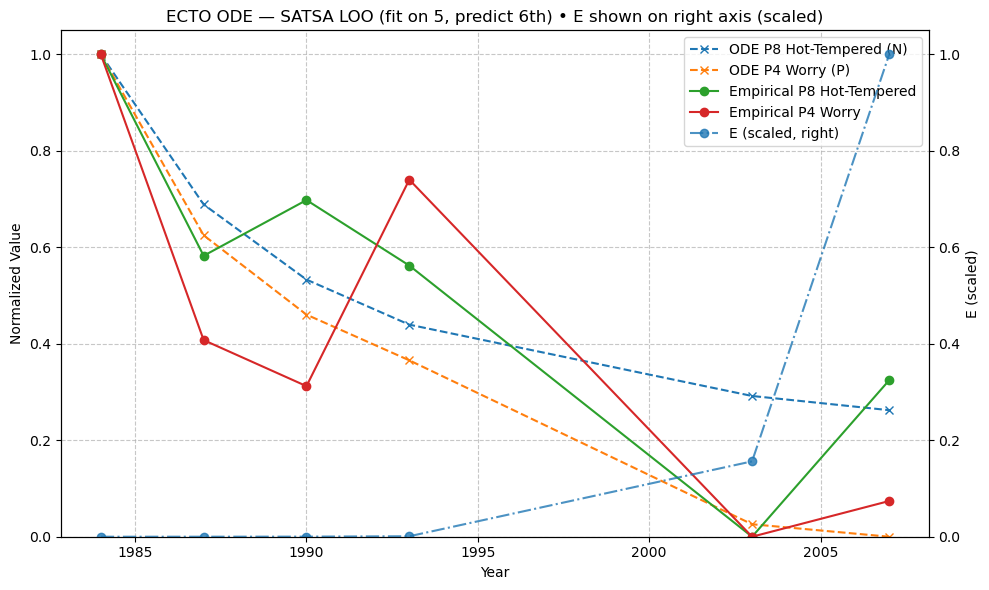

In [3]:
 # Leave-One-Out (LOO) Cross-Validation with Partial Parameter Fitting 
# Note: This cell corresponds with MODULE B_6 : Statistical Validation I
#      
# SATSA LOO (leave-one-out) with optimizer; E on right axis (scaled)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score

# ---------------- Data (SATSA table) ----------------
# Choose 2 of the following: 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28: Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8: Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1: Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1: Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2: Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

# Insert full label of 2 chosen traits
trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"], dtype=float)
t_full = years - years[0]   # real year gaps (not 0..5)

def normalize(a):
    a = np.asarray(a, float); r = a.max() - a.min()
    return (a - a.min())/r if r > 0 else np.zeros_like(a)

N_emp = normalize(df[trait_x].values)
P_emp = normalize(df[trait_y].values)
waves = [f"D{i+1}" for i in range(len(years))]

# ---------------- ECTO ODE System ----------------
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) if (N + K) != 0 else 0.0
    return [dNdt, dPdt, dEdt]

# ---------------- Optimizer setup ----------------
# Starting 'neighborhood' settings chosen for illustrative purposes
initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]  # [mu,alpha,beta,gamma,c1,c2,c3,K]
bounds = [
    (1e-6, 0.02),   # mu   (slow net growth fits SATSA scale)
    (0.001, 0.8),   # alpha
    (0.01, 0.5),    # beta
    (0.01, 0.8),    # gamma
    (0.2,  2.5),    # c1
    (0.2,  2.5),    # c2
    (0.0,  2.0),    # c3
    (0.2,  2.0),    # K
]

eps = 1e-8  # tiny epsilon to avoid exact 0 invariants

def objective(params, obs_idx):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    y0 = [max(N_emp[0], eps), max(P_emp[0], eps), 0.05]
    sol = odeint(system, y0, t_full, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
    N_mod, P_mod = sol[:,0], sol[:,1]
    errN = np.sum((N_mod[obs_idx] - N_emp[obs_idx])**2)
    errP = np.sum((P_mod[obs_idx] - P_emp[obs_idx])**2)
    return errN + errP

def fit_fold(obs_idx, x0=None):
    if x0 is None:
        x0 = initial_guess
    res = minimize(lambda p: objective(p, obs_idx), x0, bounds=bounds, method='L-BFGS-B')
    return res

def simulate(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    y0 = [max(N_emp[0], eps), max(P_emp[0], eps), 0.05]
    sol = odeint(system, y0, t_full, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
    return sol.T  # N_model, P_model, E_model


# Leave One Out (LOO) Analysis (6 folds)
all_idx = np.arange(len(years))
print("=== LOO (hold one time point; fit on the other five) ===")
held = []
for hold in all_idx:
    obs_idx = np.delete(all_idx, hold)
    res = fit_fold(obs_idx)
    params = res.x
    N_mod, P_mod, _ = simulate(params)
    out = (years[hold], float(N_emp[hold]), float(N_mod[hold]), float(P_emp[hold]), float(P_mod[hold]), res.message, float(res.fun))
    held.append(out)
    print(f"Hold {int(out[0])} | N_true={out[1]:.3f} N_pred={out[2]:.3f} | "
          f"P_true={out[3]:.3f} P_pred={out[4]:.3f} | {out[5]} | SSE={out[6]:.6f}")

N_rmse = np.sqrt(np.mean([(h[2]-h[1])**2 for h in held]))
P_rmse = np.sqrt(np.mean([(h[4]-h[3])**2 for h in held]))
print(f"\nLOO RMSE — {trait_x}: {N_rmse:.4f} | {trait_y}: {P_rmse:.4f}")

# ---------------- Full-data fit (for display/metrics) ----------------
res_full = fit_fold(all_idx)
params_full = res_full.x
N_model, P_model, E_model = simulate(params_full)

rmse_N = np.sqrt(mean_squared_error(N_emp, N_model))
rmse_P = np.sqrt(mean_squared_error(P_emp, P_model))
r2_N = r2_score(N_emp, N_model)
r2_P = r2_score(P_emp, P_model)

print("\n=== Full-data fit (display) ===")
print("Optimizer:", res_full.message, "| SSE=", float(res_full.fun))
print(f"Params (mu,alpha,beta,gamma,c1,c2,c3,K) = {[float(x) for x in params_full]}")
print(f"RMSE {trait_x}={rmse_N:.4f} (R²={r2_N:.4f}) | RMSE {trait_y}={rmse_P:.4f} (R²={r2_P:.4f})")

# ---------------- Plot (E on right axis, scaled) ----------------
    # This step is for visual 
plt.figure(figsize=(10,6))
ax1 = plt.gca()

ax1.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
ax1.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
ax1.plot(years, N_emp, 'o-', label=f'Empirical {trait_x}')
ax1.plot(years, P_emp, 'o-', label=f'Empirical {trait_y}')
ax1.set_xlabel("Year")
ax1.set_ylabel("Normalized Value")
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0, 1.05)

ax2 = ax1.twinx()
E_plot = E_model / (np.max(E_model) if np.max(E_model)>0 else 1.0)
ax2.plot(years, E_plot, 'o-.', alpha=0.8, label='E (scaled, right)')
ax2.set_ylabel("E (scaled)")
ax2.set_ylim(0, 1.05)

lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title("ECTO ODE — SATSA LOO (fit on 5, predict 6th) • E shown on right axis (scaled)")
plt.tight_layout()
plt.show()


In [10]:
# Glue Cell — make sure SATSA variables exist in this notebook scope.

import numpy as np
from scipy.integrate import odeint

# 0) Define system() if not already present (same as SATSA module)
try:
    system
except NameError:
    def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
        N, P, E = y
        E_dynamic = c1 * P + c2 * N + c3 * E
        dNdt = mu * N - alpha * N**2 - (beta**2) * N * P
        dPdt = mu * P - beta * P * E_dynamic
        dEdt = gamma * E * (N / (N + K)) if (N + K) != 0 else 0.0
        return [dNdt, dPdt, dEdt]

# 1) Ensure N_empirical, P_empirical, years, t_data exist
def _normalize(a):
    a = np.asarray(a, float)
    r = a.max() - a.min()
    return (a - a.min())/r if r > 0 else np.zeros_like(a)

needs_build = False
try:
    _ = N_empirical, P_empirical
except NameError:
    # try alias from earlier 4-wave naming
    try:
        N_empirical = N_emp
        P_empirical = P_emp
    except NameError:
        needs_build = True

if needs_build:
    # Recreate from SATSA script (P8 Hot-Tempered vs P4 Worry)
    years = np.array([1984, 1987, 1990, 1993, 2003, 2007], dtype=float)
    P8 = np.array([2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556], dtype=float)  # N-series
    P4 = np.array([2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279], dtype=float)  # P-series
    N_empirical = _normalize(P8)
    P_empirical = _normalize(P4)

# 2) Ensure years and t_data exist
try:
    years
except NameError:
    years = np.array([1984, 1987, 1990, 1993, 2003, 2007], dtype=float)
try:
    t_data
except NameError:
    t_data = years - years[0]

# 3) 8-param optimizer defaults for SATSA (same neighborhood you reported)
initial_guess8 = [0.02, 0.17, 0.08, 0.80, 2.50, 0.20, 0.007, 0.20]  # [mu,alpha,beta,gamma,c1,c2,c3,K]
bounds8 = [
    (1e-6, 0.02),   # mu
    (0.001, 0.8),   # alpha
    (0.01, 0.5),    # beta
    (0.01, 0.8),    # gamma
    (0.2,  2.5),    # c1
    (0.2,  2.5),    # c2
    (0.0,  2.0),    # c3
    (0.2,  2.0),    # K
]

# 4) Stash reported full-fit params so Cell 'Local Sensitivity' can use them without refitting
try:
    params_full_8
except NameError:
    params_full_8 = np.array([0.02, 0.16852842030743426, 0.08330474143191831,
                              0.8, 2.5, 0.2, 0.007451536865921262, 0.2], float)


In [12]:
# --- SATSA Cell Local sensitivity (±10%) for all 8 parameters ---

import numpy as np
from sklearn.metrics import mean_squared_error

# If you still have the full-fit params in scope from your SATSA fit, use them; else refit quickly:
try:
    params_full_8 = params_full_8  # keep if already defined
except NameError:
    # quick full-data refit to get params
    res_full_sat = minimize(
        lambda th: np.sum((odeint(system, [max(N_empirical[0], 1e-8), max(P_empirical[0], 1e-8), 0.05],
                                    t_data, args=(th[0], th[1], th[2], th[3], th[4], th[5], th[6], th[7]))[:,0] - N_empirical)**2) +
                           np.sum((odeint(system, [max(N_empirical[0], 1e-8), max(P_empirical[0], 1e-8), 0.05],
                                    t_data, args=(th[0], th[1], th[2], th[3], th[4], th[5], th[6], th[7]))[:,1] - P_empirical)**2),
        x0=initial_guess8, bounds=bounds8, method='L-BFGS-B'
    )
    params_full_8 = res_full_sat.x

names8 = ["mu","alpha","beta","gamma","c1","c2","c3","K"]
theta0 = np.array(params_full_8, float)

def total_rmse_from_params8(th):
    mu, alpha, beta, gamma, c1, c2, c3, K = th
    y0 = [max(N_empirical[0], 1e-8), max(P_empirical[0], 1e-8), 0.05]
    sol = odeint(system, y0, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
    N_mod, P_mod = sol[:,0], sol[:,1]
    rmseN = np.sqrt(mean_squared_error(N_empirical, N_mod))
    rmseP = np.sqrt(mean_squared_error(P_empirical, P_mod))
    total = float(np.sqrt(0.5*(rmseN**2 + rmseP**2)))
    return total, float(rmseN), float(rmseP)

base_total, baseN, baseP = total_rmse_from_params8(theta0)

print("Param  |  Δ   | RMSE_total(base)  RMSE_total(pert)   Δ%     RMSE_N  RMSE_P")
for i, name in enumerate(names8):
    for frac, label in [(+0.10, "+10%"), (-0.10, "−10%")]:
        th = theta0.copy()
        th[i] = theta0[i] * (1.0 + frac)
        tot, rN, rP = total_rmse_from_params8(th)
        rel = 100.0 * (tot - base_total) / base_total
        print(f"{name:6s} | {label:>3s} |      {base_total:.4f}           {tot:.4f}     {rel:+6.1f}%   {rN:.4f}  {rP:.4f}")


Param  |  Δ   | RMSE_total(base)  RMSE_total(pert)   Δ%     RMSE_N  RMSE_P
mu     | +10% |      0.1728           0.1728       +0.0%   0.1546  0.1893
mu     | −10% |      0.1728           0.1728       +0.0%   0.1538  0.1900
alpha  | +10% |      0.1728           0.1735       +0.4%   0.1556  0.1897
alpha  | −10% |      0.1728           0.1737       +0.5%   0.1561  0.1896
beta   | +10% |      0.1728           0.1732       +0.2%   0.1542  0.1903
beta   | −10% |      0.1728           0.1733       +0.3%   0.1541  0.1906
gamma  | +10% |      0.1728           0.1731       +0.2%   0.1543  0.1900
gamma  | −10% |      0.1728           0.1747       +1.1%   0.1540  0.1933
c1     | +10% |      0.1728           0.1731       +0.2%   0.1541  0.1901
c1     | −10% |      0.1728           0.1732       +0.3%   0.1541  0.1904
c2     | +10% |      0.1728           0.1728       +0.0%   0.1541  0.1896
c2     | −10% |      0.1728           0.1728       -0.0%   0.1541  0.1896
c3     | +10% |      0.1728          

In [14]:
# --- SATSA Cell : Multistart fits to check robustness ---

import numpy as np

seeds = [1, 11, 21, 31, 41, 51, 61, 71]
sses = []
thetas = []

for sd in seeds:
    rng = np.random.default_rng(sd)
    # jitter around your full-data solution (±20%)
    jitter = 1.0 + 0.20 * rng.uniform(-1, 1, size=len(params_full))
    x0 = params_full * jitter  # [mu, alpha, gamma, E0, beta, c1]
    res = minimize(lambda p: objective(p, np.arange(4)), x0, bounds=bounds, method='L-BFGS-B')
    sses.append(float(res.fun))
    thetas.append(res.x)

sses = np.array(sses)
print(f"Multistart SSE — mean={sses.mean():.6f}, sd={sses.std():.6f}, "
      f"min={sses.min():.6f}, max={sses.max():.6f}")

# (Optional) print a compact param table
for i, th in enumerate(thetas):
    print(f"Seed {seeds[i]:>2}: {['%.4f'%v for v in th]}")


Multistart SSE — mean=0.245994, sd=0.000040, min=0.245971, max=0.246079
Seed  1: ['0.0200', '0.1270', '0.0890', '0.7986', '2.3147', '0.2000', '0.0000', '0.2014']
Seed 11: ['0.0200', '0.1278', '0.0830', '0.6516', '2.5000', '0.2000', '0.0000', '0.2000']
Seed 21: ['0.0200', '0.1304', '0.0819', '0.6663', '2.4999', '0.2003', '0.0000', '0.2017']
Seed 31: ['0.0200', '0.1278', '0.0830', '0.7897', '2.5000', '0.2000', '0.0000', '0.2014']
Seed 41: ['0.0200', '0.1278', '0.0830', '0.7989', '2.5000', '0.2000', '0.0000', '0.2092']
Seed 51: ['0.0200', '0.1278', '0.0830', '0.7105', '2.5000', '0.2000', '0.0000', '0.2192']
Seed 61: ['0.0200', '0.1278', '0.0830', '0.7948', '2.5000', '0.2000', '0.0000', '0.2406']
Seed 71: ['0.0200', '0.1278', '0.0830', '0.7957', '2.5000', '0.2000', '0.0000', '0.2041']
